### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import os

# Reproducibility
seed = 2
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Optional: disable eager execution (if using graph mode code)
tf.compat.v1.disable_eager_execution()

# Session config
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(config=session_conf)

# Set this session as default for everything that follows
# No set_session needed — use a context manager instead
with sess.as_default():
    # your model/code here
    pass


2025-05-19 12:11:09.312181: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 12:11:09.323336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747656669.339549 2545895 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747656669.342985 2545895 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747656669.353128 2545895 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *

import pandas as pd
import pickle
import time
import sys
import json
import os

# import statsmodels
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, TimeDistributed
from keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D 
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ProgbarLogger

### Import Classes

In [3]:
os.getcwd()

'/mnt/c/Users/ansel/AppData/Local/Programs/Microsoft VS Code'

In [4]:
os.chdir('/mnt/d/GitHub/WQU-Capstone/notebooks/classes')

os.getcwd()

'/mnt/d/GitHub/WQU-Capstone/notebooks/classes'

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

I0000 00:00:1747656672.077419 2545895 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9395 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

Function to evaluate forecasting results:

In [7]:
def evaluate_forecasting(n_pairs, true_values, prediction_values):
    mse, mae, rmse, accuracy, bias = list(), list(), list(), list(), list()
    std_dev = list()
    for i in range(n_pairs):
        mse.append(mean_squared_error(true_values[i], prediction_values[i]))
        rmse.append(np.sqrt(mean_squared_error(true_values[i], prediction_values[i])))
        mae.append(mean_absolute_error(true_values[i], prediction_values[i]))
        accuracy.append(forecasting_trader.calculate_direction_accuracy(true_values[i], prediction_values[i]))
        bias.append((true_values[i] - prediction_values[i]).mean())
        std_dev.append(prediction_values[i].std())
    print('{:.2f}E-4'.format(np.mean(mse)*10000))#Average MSE: 
    print('{:.2f}E-3'.format(np.mean(rmse)*1000))#Average RMSE: 
    print('{:.2f}E-3'.format(np.mean(mae)*1000))#Average RMSE: 
    print('{:.2f}%'.format(np.mean(accuracy)))#Average Directional Accuracy: 
    #print('Bias: {:.2f}E-4'.format(np.mean(bias)*10000))
    #print('Average Standard Deviation from prediction signal ', np.mean(std_dev))
    
    return mse, mae, rmse, accuracy

### LSTM

In [8]:
def plot_loss(history, title, epoch_stop, metric='mse'):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    plt.figure(figsize=(7,5))
    #plt.grid()
    if metric == 'mse':
        plt.plot(history['loss'], label = "Training MSE")
        plt.plot(history['val_loss'], label = "Validation MSE")
        plt.plot([epoch_stop], [history['val_loss'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MSE:{:.3f}'.format(history['val_loss'][epoch_stop]),
            xy=(epoch_stop, history['val_loss'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Squared Error', size=12)
    elif metric == 'mae':
        plt.plot(history['mean_absolute_error'], label = "Training MAE")
        plt.plot(history['val_mean_absolute_error'], label = "Validation MAE")
        plt.plot([epoch_stop], [history['val_mean_absolute_error'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MAE:{:.3f}'.format(history['val_mean_absolute_error'][epoch_stop]),
            xy=(epoch_stop, history['val_mean_absolute_error'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Absolute Error', size=12)
    plt.xlabel('Epochs', size=12)
    plt.legend()
    plt.savefig('{}_history.png'.format(metric), bbox='tight')
    
def plot_predictions(summaries):
    
    n_pairs = len(summaries)
    fig, ax = plt.subplots(n_pairs, 1, figsize=(20,25))
    
    for i in range(n_pairs):
        #title('Pair: {}'.format(i))
        predictions = summaries[i]['prediction(t)']
        spread = summaries[i]['spread(t)']
        ax[i].plot(predictions, 'b')
        ax[i].plot(spread, 'r')
    return None

In [9]:
def read_models(path='models/'):
    all_models = [] # Creates an empty list
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".pkl"):
                with open(path+file, 'rb') as f:
                    models = pickle.load(f)
                all_models.append(models)
                
    return all_models

In [10]:
current_path='/mnt/d/GitHub/WQU-Capstone/notebooks/PCA_75etf' #current_path=('/mnt/d/GitHub/WQU-Capstone/data/')
with open(f'{current_path}/PCA_selected_pairs.pickle', 'rb') as handle: 
    pairs = pickle.load(handle)
len(pairs)

9

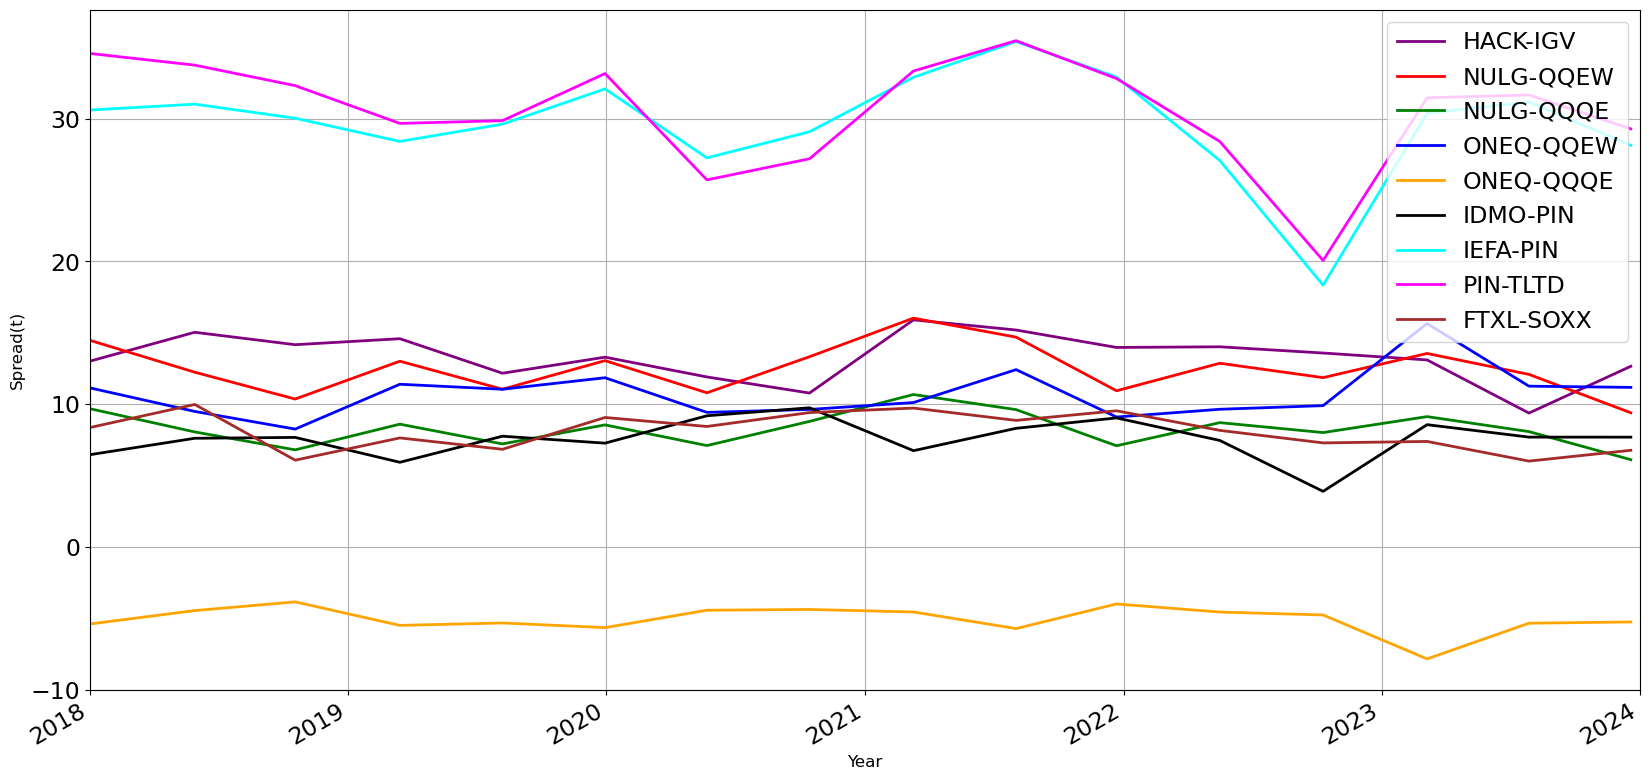

In [11]:
#markers= ["o","s","+","x","<"]
plt.rcParams.update({'font.size': 17})
colors = [
    'purple', 'red', 'green', 'blue', 'orange',
    'black', 'cyan', 'magenta', 'brown', 'pink',
    'gray', 'olive', 'teal', 'navy', 'gold'
]
for i in range(len(pairs)):
    pairs[i][2]['spread'][::100].plot(figsize=(20,10), grid=True, label='{}-{}'.format(pairs[i][0],pairs[i][1]), c=colors[i % len(colors)], linewidth=2)
plt.ylabel('Spread(t)',size=12)
plt.xlabel('Year',size=12)
plt.xlim(('2018', '2024'))
plt.legend()
#plt.savefig('spreads.png', bbox_inches='tight', pad_inches=0.05)

## Validation Set

In [12]:
rnn_models = read_models(path=f'{current_path}/models/lstm/') 
rnn_models

[[{'leg1': 'HACK',
   'leg2': 'IGV',
   'standardization_dict': 'scaler',
   'history': {'loss': [0.5431565642356873,
     0.3795328140258789,
     0.29325637221336365,
     0.2403886765241623,
     0.20978693664073944,
     0.19130317866802216,
     0.17824839055538177,
     0.16779647767543793,
     0.15878590941429138,
     0.15060824155807495,
     0.14294962584972382,
     0.13567759096622467,
     0.12874476611614227,
     0.12213534116744995,
     0.11584708839654922,
     0.10988123714923859,
     0.10423693060874939,
     0.098910853266716,
     0.09389985352754593,
     0.0892033725976944,
     0.08482436835765839,
     0.08076974749565125,
     0.07704903185367584,
     0.07367119938135147,
     0.07064027339220047,
     0.06795050948858261,
     0.06558245420455933,
     0.06350146979093552,
     0.06166047975420952,
     0.06000593677163124,
     0.05848599597811699,
     0.05705701932311058,
     0.055687472224235535,
     0.054357826709747314,
     0.05305829271674156,
 

In [13]:
etf_list = pd.read_excel(f'{current_path}/tech_etfs.xlsx')
ticker_segment_dict = dict(zip(etf_list['Ticker'], etf_list['Description']))
ticker_segment_dict

{'ARKK': 'ARK Innovation ETF',
 'ARKQ': 'ARK Autonomous Technology & Robotics ETF',
 'ARKW': 'ARK Next Generation Internet ETF',
 'CIBR': 'First Trust NASDAQ Cybersecurity ETF',
 'CQQQ': 'Invesco China Technology ETF',
 'CWEB': 'Direxion Daily CSI China Internet Bull 2X Shares',
 'DTEC': 'ALPS Disruptive Technologies ETF',
 'FDN': 'First Trust Dow Jones Internet Index Fund',
 'FTC': 'First Trust Large Cap Growth AlphaDEX Fund',
 'FTEC': 'Fidelity MSCI Information Technology Index ETF',
 'FTXL': 'First Trust Nasdaq Semiconductor ETF',
 'FXI': 'iShares China Large-Cap ETF',
 'FXL': 'First Trust Technology AlphaDEX Fund',
 'FXP': 'ProShares UltraShort FTSE China 50',
 'FYC': 'First Trust Small Cap Growth AlphaDEX Fund',
 'GAMR': 'Wedbush ETFMG Video Game Tech ETF',
 'HACK': 'ETFMG Prime Cyber Security ETF',
 'IDLV': 'Invesco S&P International Developed Low Volatility ETF',
 'IDMO': 'Invesco S&P International Developed Momentum ETF',
 'IDX': 'VanEck Vectors Indonesia Index ETF',
 'IEFA': '

In [14]:
# model to test
n_in = 24
hidden_nodes = [30]
low_quantile = 0.10
high_quantile = 0.90
train_val_split = '01-01-2023'

current_path=(f'{current_path}/models/lstm/')

In [15]:
model_rnn, cumret_val, sharperatio_val,summaries_rnn, balance_summaries_rnn = \
            forecasting_trader.run_specific_model(
                                                n_in, 
                                                hidden_nodes, 
                                                pairs,
                                                path=current_path,
                                                train_val_split=train_val_split,
                                                low_quantile=low_quantile, 
                                                high_quantile=high_quantile, 
                                                lag=1,
                                                )

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate


In [16]:
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
performance_rnn

[(            prediction(t)  prediction(t+1)  spread(t)  predicted_change(%)  \
  date                                                                         
  2023-01-03      13.896729                0  13.711816             0.000000   
  2023-01-04      13.720159                0  13.673610             0.060845   
  2023-01-05      13.663446                0  13.202311            -0.074328   
  2023-01-06      13.234282                0  13.244281             0.242163   
  2023-01-09      13.254996                0  12.620933             0.080905   
  ...                   ...              ...        ...                  ...   
  2023-12-22      12.647771                0  12.643218             1.328932   
  2023-12-26      12.806171                0  12.849719             1.288861   
  2023-12-27      13.026757                0  12.770009             1.377761   
  2023-12-28      12.929526                0  12.716532             1.249155   
  2023-12-29      12.827884             

Annual ROI:  1.1608414451267368
22.22222222222222 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  9
Positive trades:  5
Negative trades:  4
Total Drawdown Days: 63 days
Max DD period: 0 days
Maximum drawdown of portfolio: -1.12%


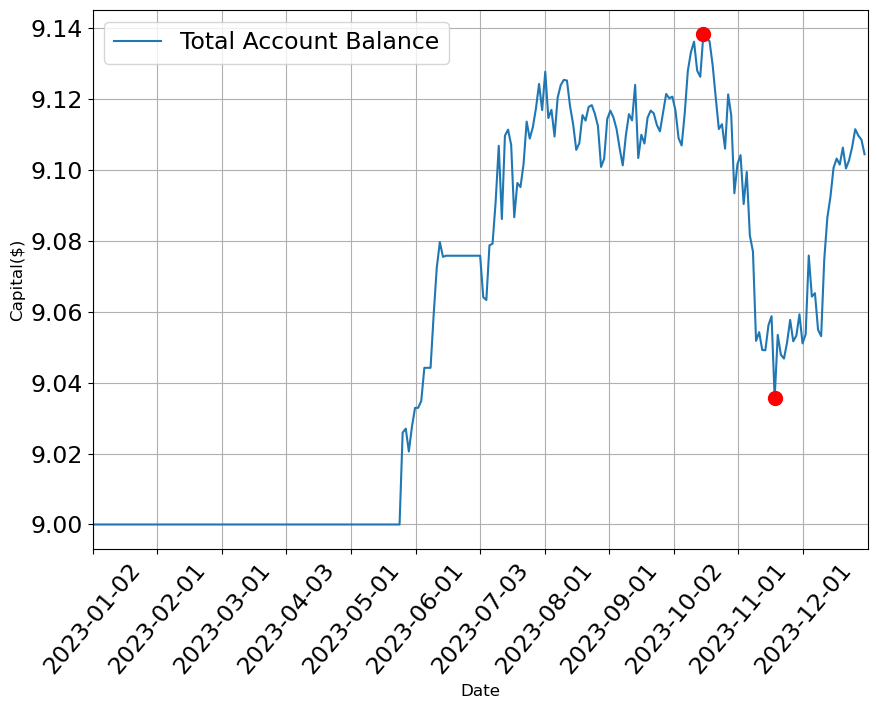

In [17]:
#print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_val,
                                                  cumret_val,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [18]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,HACK,ETFMG Prime Cyber Security ETF,IGV,iShares Expanded Tech-Software Sector ETF,-3.517100,0.007559,60,59,0.397800,1,0,1.885600,100.0
1,FTXL,First Trust Nasdaq Semiconductor ETF,SOXX,iShares PHLX Semiconductor ETF,-2.865442,0.049517,97,31,0.367213,4,1,1.591349,80.0
2,PIN,Invesco India ETF,TLTD,FlexShares Morningstar Developed Markets ex-US...,-2.924388,0.042585,45,85,0.486000,0,0,0.000000,NaN
3,IDMO,Invesco S&P International Developed Momentum ETF,PIN,Invesco India ETF,-3.662620,0.004671,109,40,0.362513,0,0,0.000000,NaN
4,IEFA,iShares Core MSCI EAFE ETF,PIN,Invesco India ETF,-2.700019,0.074035,73,77,0.471798,0,0,0.000000,NaN
5,ONEQ,Fidelity Nasdaq Composite Index ETF,QQQE,Direxion NASDAQ-100 Equal Weighted Index Shares,-2.965741,0.038220,104,40,0.444499,0,0,0.000000,NaN
6,ONEQ,Fidelity Nasdaq Composite Index ETF,QQEW,First Trust NASDAQ-100 Equal Weighted Index Fund,-3.491034,0.008220,102,38,0.437555,0,0,0.000000,NaN
7,NULG,Nuveen ESG Large-Cap Growth ETF,QQQE,Direxion NASDAQ-100 Equal Weighted Index Shares,-3.280411,0.015777,111,36,0.387442,0,1,-0.968715,0.0
8,NULG,Nuveen ESG Large-Cap Growth ETF,QQEW,First Trust NASDAQ-100 Equal Weighted Index Fund,-3.130282,0.024392,105,38,0.384859,0,2,-2.257111,0.0


In [19]:
results

{'n_pairs': 9,
 'portfolio_sharpe_ratio': np.float64(0.9969988872435249),
 'avg_total_roi': np.float64(1.1608414451267381),
 'avg_annual_roi': np.float64(1.1608414451267368),
 'pct_positive_trades_per_pair': np.float64(45.0),
 'pct_pairs_with_positive_results': 22.22222222222222,
 'avg_half_life': np.float64(49.333333333333336),
 'avg_hurst_exponent': np.float64(0.4155199656953543)}

Training:

In [20]:
init = model_rnn[0]['predictions_train'].index[0]
true_train = [pairs[i][2]['spread'][init:train_val_split] for i in range(len(pairs))]
predictions_train = [model_rnn[i]['predictions_train'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_train, predictions_train)

1095.41E-4
318.11E-3
236.81E-3
48.11%


Validation:

In [21]:
true_val = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

1245.69E-4
342.34E-3
264.08E-3
46.76%


## **Test unrestricted**

In [22]:
model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=range(len(pairs)))

performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
performance_rnn

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate


[(            prediction(t)  prediction(t+1)  spread(t)  predicted_change(%)  \
  date                                                                         
  2024-02-06      12.751501                0  13.179680             0.000000   
  2024-02-07      13.172894                0  13.828806            -0.051483   
  2024-02-08      13.881944                0  14.075734             0.384256   
  2024-02-09      14.134486                0  15.247844             0.417404   
  2024-02-12      15.303732                0  15.258159             0.366528   
  ...                   ...              ...        ...                  ...   
  2024-12-24      15.232984                0  15.055052             0.431817   
  2024-12-26      15.202885                0  15.669591             0.981947   
  2024-12-27      15.780847                0  15.812625             0.710012   
  2024-12-30      15.932220                0  15.633184             0.756325   
  2024-12-31      15.693070             

Annual ROI:  -4.74054824496315
33.333333333333336 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  12
Positive trades:  7
Negative trades:  5
Total Drawdown Days: 126 days
Max DD period: 2 days
Maximum drawdown of portfolio: -5.47%


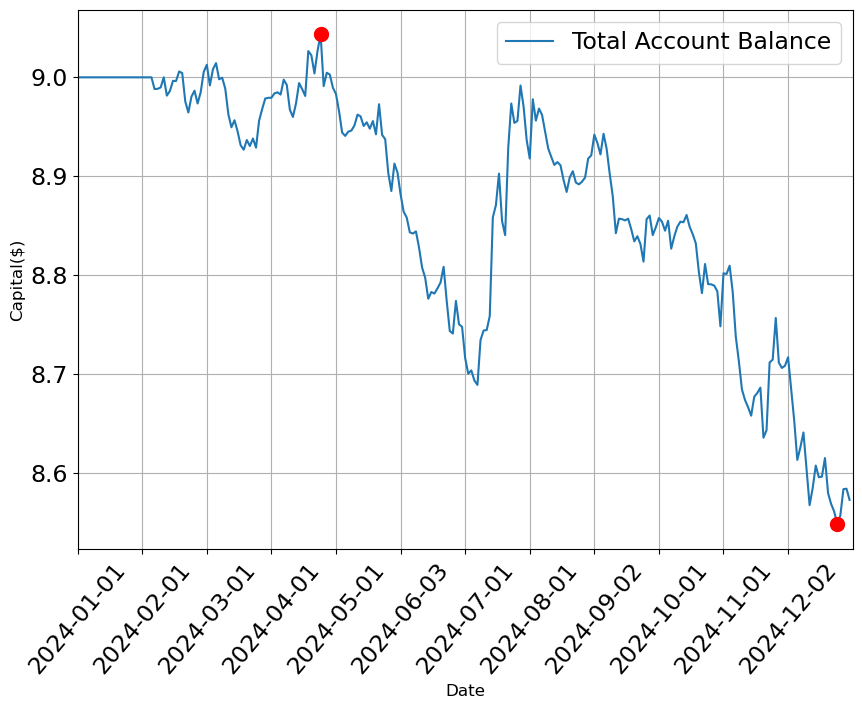

In [23]:
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [24]:
results

{'n_pairs': 9,
 'portfolio_sharpe_ratio': np.float64(-1.175975402133072),
 'avg_total_roi': np.float64(-4.740548244963146),
 'avg_annual_roi': np.float64(-4.74054824496315),
 'pct_positive_trades_per_pair': np.float64(40.47619047619048),
 'pct_pairs_with_positive_results': 33.333333333333336,
 'avg_half_life': np.float64(49.333333333333336),
 'avg_hurst_exponent': np.float64(0.4155199656953543)}

In [25]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,IDMO,Invesco S&P International Developed Momentum ETF,PIN,Invesco India ETF,-3.662620,0.004671,109,40,0.362513,1,0,1.801494,100.000000
1,FTXL,First Trust Nasdaq Semiconductor ETF,SOXX,iShares PHLX Semiconductor ETF,-2.865442,0.049517,97,31,0.367213,5,1,1.146240,83.333333
2,HACK,ETFMG Prime Cyber Security ETF,IGV,iShares Expanded Tech-Software Sector ETF,-3.517100,0.007559,60,59,0.397800,1,0,0.634625,100.000000
3,IEFA,iShares Core MSCI EAFE ETF,PIN,Invesco India ETF,-2.700019,0.074035,73,77,0.471798,0,0,0.000000,NaN
4,PIN,Invesco India ETF,TLTD,FlexShares Morningstar Developed Markets ex-US...,-2.924388,0.042585,45,85,0.486000,0,0,0.000000,NaN
5,NULG,Nuveen ESG Large-Cap Growth ETF,QQEW,First Trust NASDAQ-100 Equal Weighted Index Fund,-3.130282,0.024392,105,38,0.384859,0,1,-1.512776,0.000000
6,ONEQ,Fidelity Nasdaq Composite Index ETF,QQEW,First Trust NASDAQ-100 Equal Weighted Index Fund,-3.491034,0.008220,102,38,0.437555,0,1,-1.519284,0.000000
7,NULG,Nuveen ESG Large-Cap Growth ETF,QQQE,Direxion NASDAQ-100 Equal Weighted Index Shares,-3.280411,0.015777,111,36,0.387442,0,1,-1.680366,0.000000
8,ONEQ,Fidelity Nasdaq Composite Index ETF,QQQE,Direxion NASDAQ-100 Equal Weighted Index Shares,-2.965741,0.038220,104,40,0.444499,0,1,-1.765626,0.000000


Test:

In [26]:
true_test = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_test, predictions)

179168.22E-4
2999.65E-3
2432.26E-3
48.14%


## **Test with active pairs on validation set**

In [27]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=profitable_pairs_indices)
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(profitable_pairs))]
performance_rnn

Not considering risk-free rate
Not considering risk-free rate


[(            prediction(t)  prediction(t+1)  spread(t)  predicted_change(%)  \
  date                                                                         
  2024-02-06      12.751501                0  13.179680             0.000000   
  2024-02-07      13.172894                0  13.828806            -0.051483   
  2024-02-08      13.881944                0  14.075734             0.384256   
  2024-02-09      14.134486                0  15.247844             0.417404   
  2024-02-12      15.303732                0  15.258159             0.366528   
  ...                   ...              ...        ...                  ...   
  2024-12-24      15.232984                0  15.055052             0.431817   
  2024-12-26      15.202885                0  15.669591             0.981947   
  2024-12-27      15.780847                0  15.812625             0.710012   
  2024-12-30      15.932220                0  15.633184             0.756325   
  2024-12-31      15.693070             

Annual ROI:  11.450713579177174
100.0 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  7
Positive trades:  6
Negative trades:  1
Total Drawdown Days: 99 days
Max DD period: 0 days
Maximum drawdown of portfolio: -5.92%


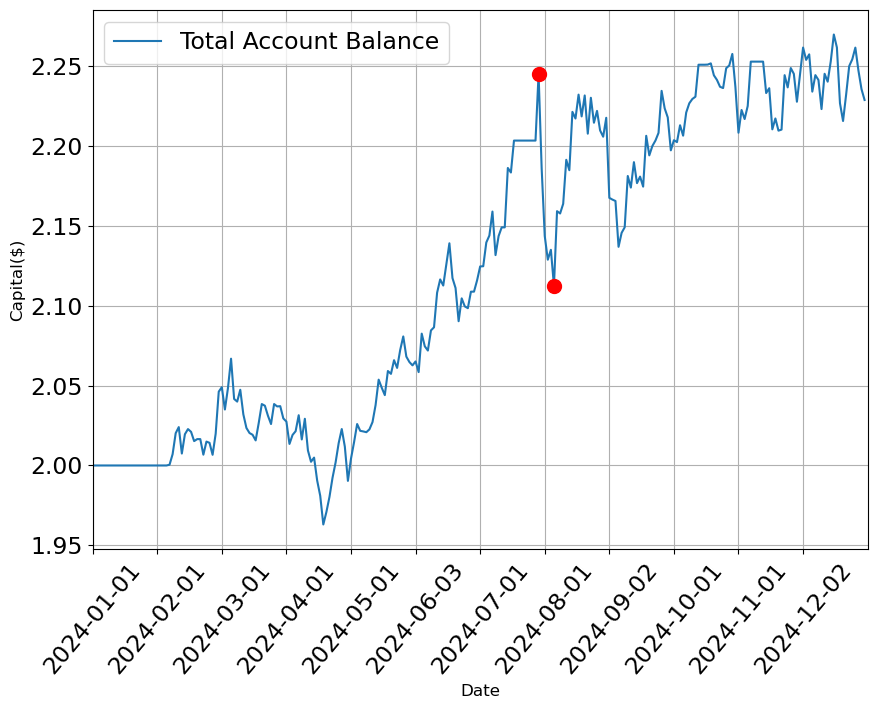

In [28]:
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years=1)

In [29]:
results

{'n_pairs': 2,
 'portfolio_sharpe_ratio': np.float64(1.1980109752080979),
 'avg_total_roi': np.float64(11.450713579177174),
 'avg_annual_roi': np.float64(11.450713579177174),
 'pct_positive_trades_per_pair': np.float64(91.66666666666667),
 'pct_pairs_with_positive_results': 100.0,
 'avg_half_life': np.float64(45.0),
 'avg_hurst_exponent': np.float64(0.3825064879178623)}

In [30]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,FTXL,First Trust Nasdaq Semiconductor ETF,SOXX,iShares PHLX Semiconductor ETF,-2.865442,0.049517,97,31,0.367213,5,1,1.146240,83.333333
1,HACK,ETFMG Prime Cyber Security ETF,IGV,iShares Expanded Tech-Software Sector ETF,-3.517100,0.007559,60,59,0.397800,1,0,0.634625,100.000000
